In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import numpy as np
from scipy import stats
import pickle
import torch
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import ltrRNN
from ltrRNN.rnn_architectures.tensor_rank import *
from ltrRNN.helper import control, classes, functions
from ltrRNN.sde.systems import SDE
from ltrRNN.plotting import utils

from NetFormer import tools, data

In [3]:
plt.rcParams.update({
    'axes.titlesize': 14,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'font.size': 14
})

## Process Neural Data

In [ ]:
input_mouse = ['SB025']
input_sessions = [['2019-10-23']]

window_size = 60
split_ratio = 0.8

directory = '../../data/Mouse/Bugeon/'
input_sessions_file_path = []
for i in range(len(input_mouse)):
    for j in range(len(input_sessions[i])):
        input_sessions_file_path.append({'date_exp': input_mouse[i] + '/' + input_sessions[i][j] + '/', 'input_setting': 'Blank/01/'})
        print(input_mouse[i] + '/' + input_sessions[i][j])

all_sessions_original_UniqueID = []
all_sessions_original_cell_type = []

all_sessions_acitvity_TRAIN = []   # first 80% of the time
all_sessions_acitvity_TEST = []

all_sessions_state_TRAIN = []
all_sessions_state_TEST = []

num_neurons_per_session = []
sessions_2_original_cell_type = []
all_sessions_activity_flatten = []

for i in range(len(input_sessions_file_path)):
    date_exp = input_sessions_file_path[i]['date_exp']
    input_setting = input_sessions_file_path[i]['input_setting']
    activity, frame_states, frame_times, UniqueID, neuron_ttypes = data.load_mouse_data_session(
        directory, date_exp, input_setting, normalization="no"
    )
    frame_states = frame_states.flatten()

    all_sessions_original_UniqueID.append(UniqueID)
    all_sessions_acitvity_TRAIN.append(activity[:, :int(activity.shape[1]*split_ratio)])
    all_sessions_acitvity_TEST.append(activity[:, int(activity.shape[1]*split_ratio):])
    all_sessions_state_TRAIN.append(frame_states[:int(activity.shape[1]*split_ratio)])
    all_sessions_state_TEST.append(frame_states[int(activity.shape[1]*split_ratio):])
    num_neurons_per_session.append(activity.shape[0])
    all_sessions_activity_flatten.append(activity.flatten())

    # Get the first level of cell types
    neuron_types_result = []
    for j in range(len(neuron_ttypes)):
        # split by "-"
        neuron_types_result.append(neuron_ttypes[j].split("-")[0])

    sessions_2_original_cell_type.append(neuron_types_result)
    all_sessions_original_cell_type.append(neuron_types_result)

all_sessions_original_UniqueID = np.concatenate(all_sessions_original_UniqueID)
all_sessions_original_cell_type = np.concatenate(all_sessions_original_cell_type)
all_sessions_activity_flatten = np.concatenate(all_sessions_activity_flatten)
mu = np.mean(all_sessions_activity_flatten)
std = np.std(all_sessions_activity_flatten)

# all_sessions normalization
all_sessions_acitvity_TRAIN = [(session - mu) / std for session in all_sessions_acitvity_TRAIN]
all_sessions_acitvity_TEST = [(session - mu) / std for session in all_sessions_acitvity_TEST]

##############################################
# Construct new UniqueID and cell type id
##############################################

all_sessions_new_UniqueID, num_unqiue_neurons = tools.assign_unique_neuron_ids(all_sessions_original_UniqueID, num_neurons_per_session)
all_sessions_new_cell_type_id, cell_type_order = tools.assign_unique_cell_type_ids(all_sessions_original_cell_type, num_neurons_per_session)

neuron_id_2_cell_type_id = np.zeros((num_unqiue_neurons,)).astype(int)
for i in range(len(all_sessions_new_UniqueID)):
    neuron_id_2_cell_type_id[all_sessions_new_UniqueID[i].astype(int)] = all_sessions_new_cell_type_id[i]

##############################################
# Construct windows
##############################################

# For TRAIN
all_sessions_activity_windows_TRAIN, all_sessions_new_UniqueID_windows_TRAIN, all_sessions_new_cell_type_id_window_TRAIN, all_sessions_state_windows_TRAIN = tools.sliding_windows(
    all_sessions_acitvity_TRAIN, all_sessions_new_UniqueID, all_sessions_new_cell_type_id, all_sessions_state_TRAIN, window_size=window_size
)
# For TEST
all_sessions_activity_windows_TEST, all_sessions_new_UniqueID_windows_TEST, all_sessions_new_cell_type_id_window_TEST, all_sessions_state_windows_TEST = tools.sliding_windows(
    all_sessions_acitvity_TEST, all_sessions_new_UniqueID, all_sessions_new_cell_type_id, all_sessions_state_TEST, window_size=window_size
)

SB025/2019-10-23
no normalization
cell_type_order: ['EC', 'IN', 'Lamp5', 'Pvalb', 'Serpinf1', 'Sncg', 'Sst', 'Vip']


In [ ]:
activity_windows_TRAIN = all_sessions_activity_windows_TRAIN[0]
state_windows_TRAIN = all_sessions_state_windows_TRAIN[0]

activity_windows_TEST = all_sessions_activity_windows_TEST[0]
state_windows_TEST = all_sessions_state_windows_TEST[0]

print("activity_windows_TRAIN: ", activity_windows_TRAIN.shape)
print("state_windows_TRAIN: ", state_windows_TRAIN.shape)
print("activity_windows_TEST: ", activity_windows_TEST.shape)
print("state_windows_TEST: ", state_windows_TEST.shape)

# concat
activity_windows = np.concatenate([activity_windows_TRAIN, activity_windows_TEST], axis=0)
print("activity_windows: ", activity_windows.shape)

activity_windows = np.einsum('ijk->kij', activity_windows)       # (trial, neuron, time) -> (time, trial, neuron)

activity_windows_TRAIN:  (3095, 527, 60)
state_windows_TRAIN:  (3095, 60)
activity_windows_VAL:  (730, 527, 60)
state_windows_VAL:  (730, 60)
activity_windows:  (3825, 527, 60)


## Train LtrRNN

In [ ]:
hyperparameters = {
'seed' : 5,    # 1, 2, 3, 4, 5

# LtrRNN hyperparameters
'rnn_dim' : 527,                   
'rank' : 5,                        

'time_constant': 1.0,
'noise' : 0.0, # The RNN is driven by a Wiener process (can be useful to regularize dynamics)
'bias' : False,

'duration' : 2, # How long the RNN is simulated (e.g. real experiment seconds)

# Decoder -- the linear map from the RNN dimension to the data neuron dimension   
'orthogonal_decoder' : True, # Orthonormal map (up to scaling)
'decoder_bias' : False, # Allows for translation

# Gaussian kernel
'sigma_observation' : 0.1, # Whether to allow non-smooth trial-to-trial variability
'l' : 15, # The length of the kernel, acts like a time (trial) constant
'sigma' : 0.1, # Magnitude of trial to trial variability
'discontinuous_covariance' : False, # Requires epoch parameter if True

# Controls (input) hyperparameters
# If you have a preparatory period this will allow having trial-to-trial variability in the initial (fit to data) state
# The preparatory period is determined as times < 0
'control_preparatory' : True,
'control_execution' : False,
'fit_preparatory' : False,
'condition_specific_init' : False,
'in_space_control' : True, # whether to constrain the controls to the span of a_i's

'control_dim' : 3, # Ignored if in_space_control
'control_dnn_dim' : [150,150], # Dimensions of the layers of the DNN parameterizing the neural ODE controls
'control_hidden_dim' : 150, # Dimensions of the neural ODE controls
'time_constant_control' : 2,
'trial_rank_control' : -1, #if -1 condition-wise

# training hyperparameters
'fraction_masked' : 0.2, # Masks some entries of the tensor to help optimization    
'fraction_test' : 0.2, # Maximum fraction of entries taken by the test set (see fig. 4b)

'learning_rate' : 0.001,
'test_freq' : 50, # Frequency at which to update the plots
'regularization' : 0.01,
'regularization_function' : 'square', # 'square' or 'abs' ; the latter can make the activity sparser

# If std of the test loss over the past steps_std_convergence is less than min_std_convergence, break
'training_iterations' : 200,            
'min_std_convergence' : 0.001,
'steps_std_convergence' : 200,

'optimize' : True # Set to False if you just want to load a model
}


device=('cuda' if torch.cuda.is_available() else 'cpu')
neural_data = activity_windows

train_mask = torch.zeros(list(neural_data.shape), device=device).bool()
train_mask[:, :3095, :] = True

test_mask = torch.zeros(list(neural_data.shape), device=device).bool()
test_mask[:, 3095:, :] = True


ltrRNN.fit(
    hyperparameters, # See above
    neural_data=neural_data, # (time x trial x neuron)
    train_mask=train_mask, # (time x trial x neuron)
    test_mask=test_mask, # (time x trial x neuron)
)

## Evaluate LtrRNN

In [ ]:
device=('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(hyperparameters['seed'])
np.random.seed(hyperparameters['seed'])

condition = np.zeros(neural_data.shape[1])
times = np.linspace(0, 1, neural_data.shape[0])
epoch = np.zeros(neural_data.shape[1])
trial_ids = np.arange(neural_data.shape[1])

prep, start, stop = 0, np.argmax(times >= 0), len(times)
ts_experiment = times[prep:stop]*100

neural_data = neural_data[start:stop] if not hyperparameters['fit_preparatory'] else neural_data[prep:stop]
time_dimension, trials_dimension, neurons_dimension = neural_data.shape
condition_dimension = len(np.unique(condition))

epoch_labels = epoch[np.sort(np.unique(epoch, return_index=True)[1])]
epoch_starts = [np.argmax(epoch == e) for e in epoch_labels]

print('Dimensions - Time:', time_dimension, ' Trial:', trials_dimension, 'Neuron:', neurons_dimension, 'Condition:', condition_dimension)

normalized_condition = condition / (np.max(condition ) + 1)
neural_data, condition, trial_ids = torch.tensor(neural_data, device=device), torch.tensor(condition, device=device, dtype=torch.long), torch.tensor \
    (trial_ids, device=device)

cmap_condition=matplotlib.colormaps['hsv']
cmap_per_condition = [utils.get_cmap_black(cmap_condition(i)) for i in np.unique(normalized_condition)]

activation = torch.tanh
kernel = RationalQuadratic(hyperparameters['l'], hyperparameters['sigma'])

In [ ]:
net = TensorRankSmooth(
    hyperparameters['rnn_dim'], hyperparameters['rank'],
    trial_ids, None, kernel, epoch=epoch if hyperparameters['discontinuous_covariance'] else None,
    activation=activation, std_observation=hyperparameters['sigma_observation'],
    optimize_input_maps=True, in_space_inputs=hyperparameters['in_space_control'],
    condition=condition if hyperparameters['condition_specific_init'] else None,
    bias=hyperparameters['bias'],
    in_dims=(hyperparameters['control_dim'],),
    time_constant=hyperparameters['time_constant'],
    noise=hyperparameters['noise'], device=device
)

activation_control = torch.relu
controller = control.TrialRankController(
    hyperparameters['control_hidden_dim'], trials_dimension, condition_dimension,
    hyperparameters['control_dnn_dim'],
    time_constant=hyperparameters['time_constant_control'],
    in_dims=[],
    init='optimized', device=device, activation=activation_control
)

condition_wise_map = classes.ConditionWiseControlMap(
    condition, hyperparameters['control_hidden_dim'],
    hyperparameters['control_dim'], activation=activation,
    device=device
)
graph = np.array([[1, condition_wise_map], [0, 1]])

In [ ]:
sde_preparatory = SDE([net, controller], graph)
sde_preparatory.build_parameterization()

sde_preparatory.load_state_dict(torch.load('./runs/all/19-11-2024_20_48_04/model.pt', weights_only=True))  # Load the model
sde_preparatory.eval()

W_obs = sde_preparatory.sdes[0].construct_weight(observation=False).numpy(force=True)

In [ ]:
plt.figure()
plt.imshow(np.mean(W_obs, axis=0), aspect='auto')
plt.colorbar()
plt.savefig('./W_avg_' + str(hyperparameters['seed']) + '.png')
plt.close()

np.save('./LtrRNN_W_' + str(hyperparameters['seed']) + '.npy', W_obs)

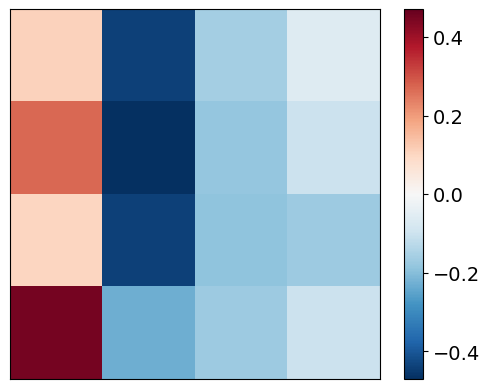

In [ ]:
eval_cell_type_order = ['EC', 'Pvalb', 'Sst', 'Vip']

KK_GT = np.zeros((4, 4))
KK_GT[0, 0] = 0.11
KK_GT[1, 0] = 0.27
KK_GT[2, 0] = 0.1
KK_GT[3, 0] = 0.45

KK_GT[0, 1] = -0.44
KK_GT[1, 1] = -0.47
KK_GT[2, 1] = -0.44
KK_GT[3, 1] = -0.23

KK_GT[0, 2] = -0.16
KK_GT[1, 2] = -0.18
KK_GT[2, 2] = -0.19
KK_GT[3, 2] = -0.17

KK_GT[0, 3] = -0.06
KK_GT[1, 3] = -0.10
KK_GT[2, 3] = -0.17
KK_GT[3, 3] = -0.10

max_abs = np.max(np.abs(KK_GT))
vmin_KK = -max_abs
vmax_KK = max_abs

plt.imshow(KK_GT, cmap='RdBu_r', vmin=vmin_KK, vmax=vmax_KK)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
LtrRNN_W = W_obs[:3095]   # look at training trials

W_by_state = [[], [], []]  # 3 * N * neuron_num * neuron_num
print(state_windows_TRAIN.shape)

for k in range(state_windows_TRAIN.shape[0]):
    if np.all(state_windows_TRAIN[k] == state_windows_TRAIN[k][0]):
        W_by_state[state_windows_TRAIN[k][0].astype(int)].append(LtrRNN_W[k])
        
W_by_state = [np.array(W_by_state[0]), np.array(W_by_state[1]), np.array(W_by_state[2])]
print(W_by_state[0].shape)
print(W_by_state[1].shape)
print(W_by_state[2].shape)

(3095, 60)
(710, 527, 527)
(672, 527, 527)
(438, 527, 527)


In [34]:
print('number of attentions in state 0 of first session', W_by_state[0].shape)
print('number of attentions in state 1 of first session', W_by_state[1].shape)
print('number of attentions in state 2 of first session', W_by_state[2].shape)

# Flatten each attention matrix in a state
state0 = W_by_state[0].reshape(W_by_state[0].shape[0], -1)
state1 = W_by_state[1].reshape(W_by_state[1].shape[0], -1)
state2 = W_by_state[2].reshape(W_by_state[2].shape[0], -1)

# concartenate all states
state012 = np.concatenate([state0, state1, state2], axis=0)
label = np.concatenate([np.zeros(state0.shape[0]), np.ones(state1.shape[0]), 2 * np.ones(state2.shape[0])])

print('label:', label)

number of attentions in state 0 of first session (710, 527, 527)
number of attentions in state 1 of first session (672, 527, 527)
number of attentions in state 2 of first session (438, 527, 527)
label: [0. 0. 0. ... 2. 2. 2.]


(1820, 2)


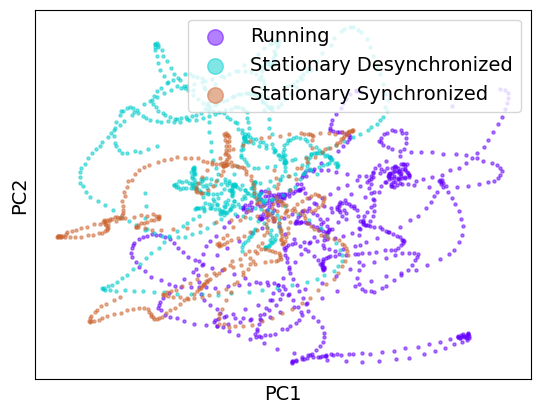

In [17]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(state012)
print(X_pca.shape)

plt.scatter(X_pca[label == 0, 0], X_pca[label == 0, 1], label='Running', alpha=0.5, s=5, c='#6600FF')
plt.scatter(X_pca[label == 1, 0], X_pca[label == 1, 1], label='Stationary Desynchronized', alpha=0.5, s=5, c='#00CCCC')
plt.scatter(X_pca[label == 2, 0], X_pca[label == 2, 1], label='Stationary Synchronized', alpha=0.5, s=5, c='#CC6633')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks([])
plt.yticks([])
plt.legend(markerscale=5)
plt.show()

In [ ]:
state0 = W_by_state[0]
state1 = W_by_state[1]
state2 = W_by_state[2]
print(state0.shape, state1.shape, state2.shape)

eval_cell_type_order = ['EC', 'Pvalb', 'Sst', 'Vip']

state0_KK = []
for i in range(state0.shape[0]):
    experiment_KK = tools.multisession_NN_to_KK(
        [state0[i]],
        cell_type_order,
        all_sessions_new_cell_type_id,
    )
    eval_KK = tools.experiment_KK_to_eval_KK(experiment_KK, cell_type_order, eval_cell_type_order)
    state0_KK.append(eval_KK)

state1_KK = []
for i in range(state1.shape[0]):
    experiment_KK = tools.multisession_NN_to_KK(
        [state1[i]],
        cell_type_order,
        all_sessions_new_cell_type_id,
    )
    eval_KK = tools.experiment_KK_to_eval_KK(experiment_KK, cell_type_order, eval_cell_type_order)
    state1_KK.append(eval_KK)

state2_KK = []
for i in range(state2.shape[0]):
    experiment_KK = tools.multisession_NN_to_KK(
        [state2[i]],
        cell_type_order,
        all_sessions_new_cell_type_id,
    )
    eval_KK = tools.experiment_KK_to_eval_KK(experiment_KK, cell_type_order, eval_cell_type_order)
    state2_KK.append(eval_KK)

print(len(state0_KK), len(state1_KK), len(state2_KK))

(710, 527, 527) (672, 527, 527) (438, 527, 527)
710 672 438


corr_state0_KK:0.15008028256593875, spearman_corr_state0_KK:0.13706739464629733
corr_state1_KK:0.13875515505783448, spearman_corr_state1_KK:0.07516599061248563
corr_state2_KK:0.13269890012244767, spearman_corr_state2_KK:0.05895371812743971


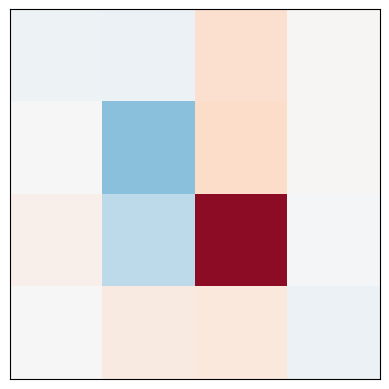

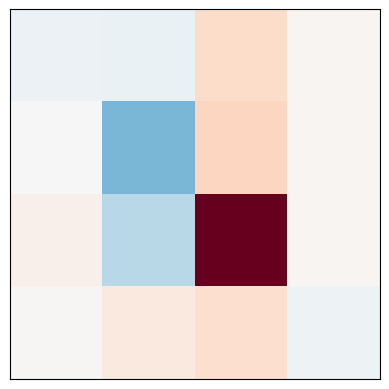

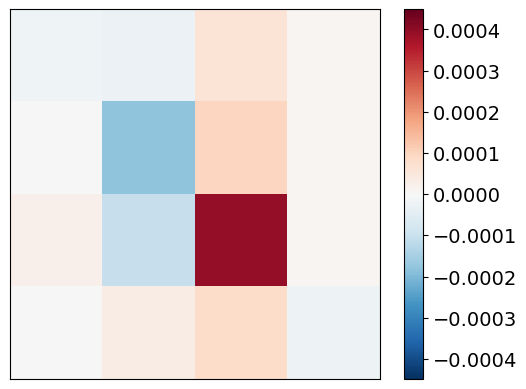

In [ ]:
state0_KK_mean = np.mean(state0_KK, axis=0)
state1_KK_mean = np.mean(state1_KK, axis=0)
state2_KK_mean = np.mean(state2_KK, axis=0)

corr_state0_KK = stats.pearsonr(KK_GT.flatten(), state0_KK_mean.flatten())[0]
spearman_corr_state0_KK = stats.spearmanr(KK_GT.flatten(), state0_KK_mean.flatten())[0]
print('corr_state0_KK:' + str(corr_state0_KK) + ', spearman_corr_state0_KK:' + str(spearman_corr_state0_KK))

corr_state1_KK = stats.pearsonr(KK_GT.flatten(), state1_KK_mean.flatten())[0]
spearman_corr_state1_KK = stats.spearmanr(KK_GT.flatten(), state1_KK_mean.flatten())[0]
print('corr_state1_KK:' + str(corr_state1_KK) + ', spearman_corr_state1_KK:' + str(spearman_corr_state1_KK))

corr_state2_KK = stats.pearsonr(KK_GT.flatten(), state2_KK_mean.flatten())[0]
spearman_corr_state2_KK = stats.spearmanr(KK_GT.flatten(), state2_KK_mean.flatten())[0]
print('corr_state2_KK:' + str(corr_state2_KK) + ', spearman_corr_state2_KK:' + str(spearman_corr_state2_KK))

# get one vmin and vmax for all states
max_abs = np.max(np.abs([state0_KK_mean, state1_KK_mean, state2_KK_mean]))
vmin_KK = -max_abs
vmax_KK = max_abs

plt.imshow(state0_KK_mean, cmap='RdBu_r', vmin=vmin_KK, vmax=vmax_KK)
plt.xticks([])
plt.yticks([])
plt.show()
plt.imshow(state1_KK_mean, cmap='RdBu_r', vmin=vmin_KK, vmax=vmax_KK)
plt.xticks([])
plt.yticks([])
plt.show()
plt.imshow(state2_KK_mean, cmap='RdBu_r', vmin=vmin_KK, vmax=vmax_KK)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()